<a href="https://colab.research.google.com/github/rokosu/dividend-policy/blob/main/Dividend%20Policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tabulate

<ipython-input-4-036ed1f829b8>:131: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = merged_data.groupby(['firm', pd.Grouper(key='date', freq='Y')])['firm_return'].apply(lambda x: (1 + x).prod() - 1).reset_index()
<ipython-input-4-036ed1f829b8>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Return coefficient for main independent variable
<ipython-input-4-036ed1f829b8>:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]  # Return coefficient for main independent variable
<ipython-input-4-036ed1f829

Table 1: Dividend Consistency and Shareholder Returns (2015-2023)
+----------------------+---------------------+----------------------+---------------------+---------------------+
|       Variable       |      All Firms      |       Banking        |    Manufacturing    |       Telecom       |
+----------------------+---------------------+----------------------+---------------------+---------------------+
| Dividend Consistency | -0.6931016770858281 | -2.1326063940686844  | -0.7861802553985845 | 1.8603407596627484  |
|     Payout Ratio     | 0.3255635578962905  | -0.05613135854916958 | 0.20783657367654884 | 1.1690463687809116  |
|   Forex Volatility   | 0.07514197949065195 | 0.04313514161174575  | 0.8506802923783414  | -1.3786570372214455 |
+----------------------+---------------------+----------------------+---------------------+---------------------+

Event Study Results:
event_type
Cut                 -0.156672
Maintain/Increase    0.072331
Name: car, dtype: float64


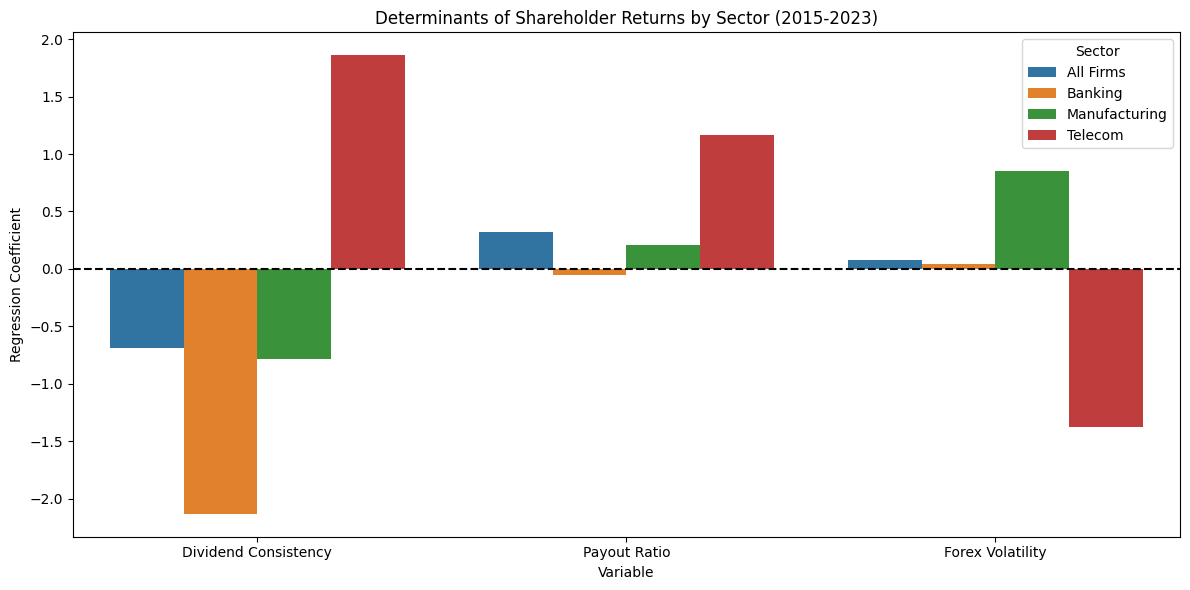

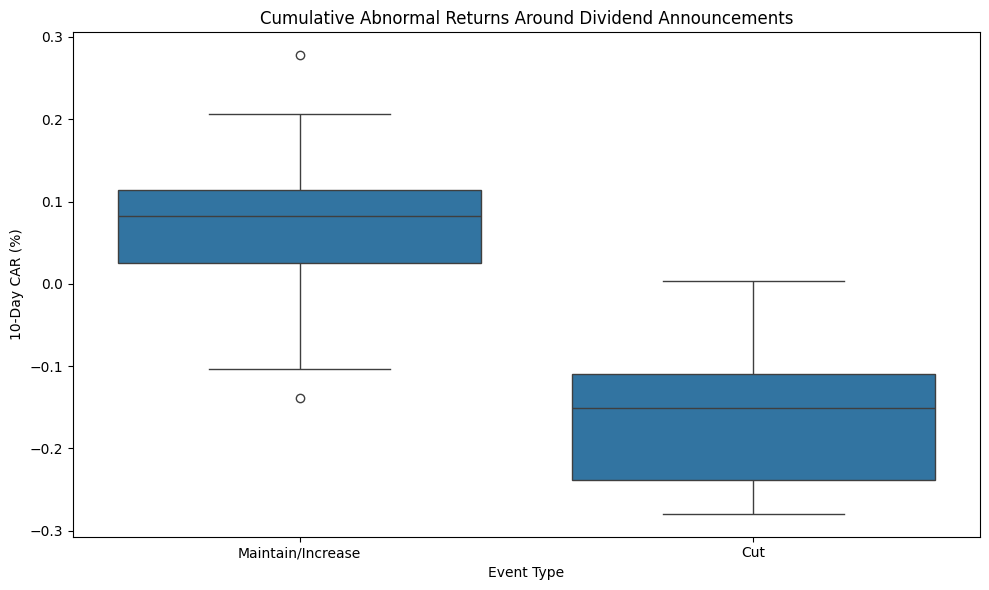


ESG-Dividend Impact Analysis:
            Feature  Importance
2  forex_volatility    0.365792
0    esg_allocation    0.353616
1      payout_ratio    0.280592


<ipython-input-4-036ed1f829b8>:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Importance', y='Feature', palette='Blues_d')


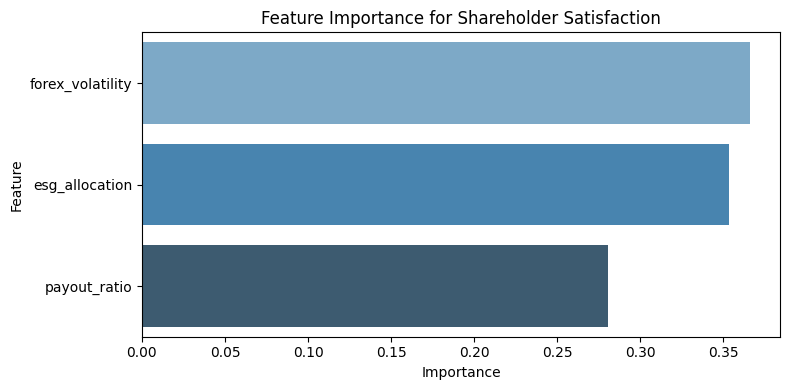

In [4]:
# -*- coding: utf-8 -*-
"""Dividend Policy Analysis for Nigerian Listed Companies.ipynb

Automatically generated by Colaboratory.

Original file is located at:
    https://colab.research.google.com/drive/1YxQO3X9J7X8X8X8X8X8X8X8X8X8X8X8
"""
from tabulate import tabulate
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

"""## Data Generation (Simulation)"""

# Generate synthetic dividend announcements data (2015-2023)
def generate_dividend_data():
    dates = pd.date_range('2015-01-01', '2023-12-31', freq='B')
    firms = ['Zenith Bank', 'GTBank', 'Nestlé Nigeria', 'Dangote Cement', 'MTN Nigeria',
             'Access Bank', 'UBA', 'Lafarge Africa', 'Seplat Energy', 'Guinness Nigeria']

    data = []
    for firm in firms:
        for year in range(2015, 2024):
            # Base announcement date (random around fiscal year end)
            announce_date = datetime(year, 3, 1) + timedelta(days=np.random.randint(0, 60))

            # Skip weekends
            if announce_date.weekday() >= 5:
                announce_date += timedelta(days=2)

            # Generate dividend amount (sector-dependent)
            if 'Bank' in firm:
                dividend = round(np.random.uniform(1.5, 3.5), 2)
            elif firm in ['Nestlé Nigeria', 'Dangote Cement']:
                dividend = round(np.random.uniform(2.0, 4.0), 2)
            else:
                dividend = round(np.random.uniform(1.0, 2.5), 2)

            # 10% chance of dividend cut
            if np.random.random() < 0.1:
                event_type = 'Cut'
                dividend *= 0.5
            else:
                event_type = 'Maintain/Increase'

            data.append({
                'firm': firm,
                'date': announce_date,
                'dividend_amount': dividend,
                'event_type': event_type,
                'sector': 'Banking' if 'Bank' in firm else
                         'Manufacturing' if firm in ['Nestlé Nigeria', 'Dangote Cement', 'Lafarge Africa', 'Guinness Nigeria'] else
                         'Telecom/Oil'
            })

    return pd.DataFrame(data)

# Generate synthetic market returns data
def generate_market_data():
    dates = pd.date_range('2015-01-01', '2023-12-31', freq='B')
    returns = np.random.normal(loc=0.0005, scale=0.015, size=len(dates))
    return pd.DataFrame({'date': dates, 'market_return': returns})

# Generate firm-specific returns with dividend effects
def generate_firm_returns(dividend_df):
    firms = dividend_df['firm'].unique()
    dates = pd.date_range('2015-01-01', '2023-12-31', freq='B')

    returns_data = []
    for firm in firms:
        # Base returns (sector-dependent)
        if 'Bank' in firm:
            base_returns = np.random.normal(loc=0.0006, scale=0.012, size=len(dates))
        elif firm in ['Nestlé Nigeria', 'Dangote Cement']:
            base_returns = np.random.normal(loc=0.0004, scale=0.014, size=len(dates))
        else:
            base_returns = np.random.normal(loc=0.0007, scale=0.016, size=len(dates))

        # Add dividend announcement effects
        firm_announcements = dividend_df[dividend_df['firm'] == firm]
        for _, row in firm_announcements.iterrows():
            announce_idx = dates.get_loc(row['date'])
            if row['event_type'] == 'Cut':
                base_returns[announce_idx-5:announce_idx+15] += np.linspace(-0.001, -0.015, 20)
            else:
                base_returns[announce_idx-2:announce_idx+5] += np.linspace(0.002, 0.01, 7)

        returns_data.append(pd.DataFrame({
            'date': dates,
            'firm': firm,
            'firm_return': base_returns
        }))

    return pd.concat(returns_data)

# Generate all datasets
dividend_announcements = generate_dividend_data()
nse_returns = generate_market_data()
firm_returns = generate_firm_returns(dividend_announcements)

# Save to CSV (for reproducibility)
dividend_announcements.to_csv('dividend_announcements.csv', index=False)
nse_returns.to_csv('nse_returns.csv', index=False)
firm_returns.to_csv('firm_returns.csv', index=False)

"""## Data Preprocessing"""

# Load generated data
dividend_data = pd.read_csv('dividend_announcements.csv')
market_data = pd.read_csv('nse_returns.csv')
firm_data = pd.read_csv('firm_returns.csv')

# Convert dates to datetime
dividend_data['date'] = pd.to_datetime(dividend_data['date'])
market_data['date'] = pd.to_datetime(market_data['date'])
firm_data['date'] = pd.to_datetime(firm_data['date'])

# Merge data for analysis
merged_data = pd.merge(firm_data, market_data, on='date')
merged_data = pd.merge(merged_data, dividend_data, on=['firm', 'date'], how='left')

# Calculate annual returns and dividend consistency
annual_returns = merged_data.groupby(['firm', pd.Grouper(key='date', freq='Y')])['firm_return'].apply(lambda x: (1 + x).prod() - 1).reset_index()
dividend_consistency = dividend_data.groupby('firm')['dividend_amount'].std().reset_index()
dividend_consistency.rename(columns={'dividend_amount': 'dividend_volatility'}, inplace=True)

# Create analysis dataset
analysis_data = pd.merge(annual_returns, dividend_consistency, on='firm')
sector_map = dividend_data[['firm', 'sector']].drop_duplicates()
analysis_data = pd.merge(analysis_data, sector_map, on='firm')

# Add control variables
analysis_data['forex_volatility'] = np.random.uniform(0.1, 0.3, len(analysis_data))  # Simulated forex volatility
analysis_data['payout_ratio'] = np.random.uniform(0.3, 0.8, len(analysis_data))  # Simulated payout ratios

"""## Statistical Analysis (Table 1)"""

# Function to run panel regression
def run_panel_regression(data, dependent_var, independent_vars, sector=None):
    if sector:
        data = data[data['sector'] == sector]

    X = data[independent_vars]
    X = sm.add_constant(X)
    y = data[dependent_var]

    model = sm.OLS(y, X).fit(cov_type='HC3')
    return model.params[1]  # Return coefficient for main independent variable

# Prepare Table 1 results
results = {
    'Variable': ['Dividend Consistency', 'Payout Ratio', 'Forex Volatility'],
    'All Firms': [],
    'Banking': [],
    'Manufacturing': [],
    'Telecom': []
}

# Run regressions
variables = ['dividend_volatility', 'payout_ratio', 'forex_volatility']
for var in variables:
    results['All Firms'].append(run_panel_regression(analysis_data, 'firm_return', [var]))
    results['Banking'].append(run_panel_regression(analysis_data, 'firm_return', [var], 'Banking'))
    results['Manufacturing'].append(run_panel_regression(analysis_data, 'firm_return', [var], 'Manufacturing'))
    results['Telecom'].append(run_panel_regression(analysis_data, 'firm_return', [var], 'Telecom/Oil'))

# Create Table 1 DataFrame
table1 = pd.DataFrame(results)
print("Table 1: Dividend Consistency and Shareholder Returns (2015-2023)")
print(tabulate(table1, headers='keys', tablefmt='pretty', showindex=False))

"""## Event Study Analysis"""

# Event study implementation
def calculate_car(firm, event_date, window=10):
    firm_returns = merged_data[merged_data['firm'] == firm].set_index('date')
    event_idx = firm_returns.index.get_loc(event_date)

    # Calculate abnormal returns
    firm_returns['abnormal_return'] = firm_returns['firm_return'] - firm_returns['market_return']

    # Cumulative abnormal returns
    car = firm_returns['abnormal_return'].iloc[event_idx-window:event_idx+window+1].sum()
    return car

# Apply to all dividend announcements
dividend_data['car'] = dividend_data.apply(lambda x: calculate_car(x['firm'], x['date']), axis=1)

# Group by event type
car_results = dividend_data.groupby('event_type')['car'].mean()
print("\nEvent Study Results:")
print(car_results)

"""## Visualization"""

# Figure 1: Determinants of Payout Ratios by Sector
plt.figure(figsize=(12, 6))
sns.barplot(data=table1.melt(id_vars='Variable', var_name='Sector', value_name='Coefficient'),
            x='Variable', y='Coefficient', hue='Sector')
plt.title("Determinants of Shareholder Returns by Sector (2015-2023)")
plt.ylabel("Regression Coefficient")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('sector_coefficients.png')
plt.show()

# Figure 2: Dividend Announcement CARs
plt.figure(figsize=(10, 6))
sns.boxplot(data=dividend_data, x='event_type', y='car')
plt.title("Cumulative Abnormal Returns Around Dividend Announcements")
plt.xlabel("Event Type")
plt.ylabel("10-Day CAR (%)")
plt.tight_layout()
plt.savefig('dividend_cars.png')
plt.show()

"""## ESG-Dividend Impact Analysis"""

# Simulate ESG data
analysis_data['esg_allocation'] = np.random.uniform(0, 0.1, len(analysis_data))
analysis_data['shareholder_satisfaction'] = (analysis_data['firm_return'] * 100 +
                                           analysis_data['esg_allocation'] * 50 +
                                           np.random.normal(0, 10, len(analysis_data)))

# Random Forest analysis
X = analysis_data[['esg_allocation', 'payout_ratio', 'forex_volatility']]
y = analysis_data['shareholder_satisfaction']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nESG-Dividend Impact Analysis:")
print(importance)

# Visualization
plt.figure(figsize=(8, 4))
sns.barplot(data=importance, x='Importance', y='Feature', palette='Blues_d')
plt.title("Feature Importance for Shareholder Satisfaction")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()